In [47]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
from shared.autoencoderHelpers import  get_input_shape, plot_history, bgr2rgb, plot_reconstruction
import pickle,glob, cv2

In [68]:
def read_n_images(data, start, end, dataPath):
    """
    Read images (should be jpg) from a dataset (from indexes start to end).
    :param data: list - image names
    :param start: int - start index
    :param end: int - end index
    :param loc: str - directory location of the images
    :return: numpy - numpy array of (BGR) image
    """
    assert glob.glob(dataPath), "Check directory."
    assert glob.glob("{}/*.jpg".format(dataPath)), "Check file extension (should be 'jpg')."
    images_list = data[start:end]
    images = [cv2.imread("{}/{}.jpg".format(dataPath, image)) for image in images_list]
    return np.array(images)

def generate_image_segmentation_labels(method,segmentationScheme ,batchSize, dataDir='', squashOutput=True):
    
    imagePath =  "{}segmentation/{}/{}/images".format(dataDir,segmentationScheme,method)
    segmentsPath = "{}segmentation/{}/{}/labels".format(dataDir,segmentationScheme,method)
    labelPath = "{}segmentation/{}/labels.pickle".format(dataDir,segmentationScheme)
    while True:
            with open(labelPath, 'rb') as f:
                data = pickle.load(f)

            methods = list(data.keys())

            assert method in methods, "'{}' not a valid mode (must be one of {})".format(method, str(methods))
            data = data[method]
            for idx in range(0, len(data), batchSize):
                start = idx
                end = idx + batchSize
                images = read_n_images(data, start, end, imagePath)
                segmentations = read_n_images(data, start, end, segmentsPath)
                if squashOutput == True:
                    segmentations = segmentations[:,:,:,0]+segmentations[:,:,:,1]+segmentations[:,:,:,2]
                    segmentations = segmentations
                    sShape = segmentations.shape
                    segmentations = segmentations.reshape((sShape[0],sShape[1],sShape[2],1))

                yield (images / 255, segmentations / 255)
                
def get_num_images(method, segmentationScheme, dataDir):
    labelPath = "{}segmentation/{}/labels.pickle".format(dataDir, segmentationScheme)
    with open(labelPath, 'rb') as f:
        data = pickle.load(f)
    data = data[method]
    return len(data)

0.9921568627450981


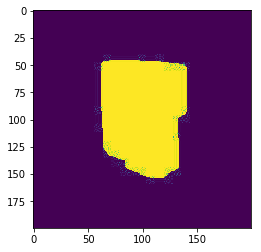

In [67]:
a = generate_image_segmentation_labels('training','foregroundBackground',10,'../data/')
data = next(a)
item = data[1][2][:,:,0]
print(item.max())
plt.imshow(item)

In [51]:
def miniUnet(inputShape,outputShape):
    inputImage = Input(shape=inputShape, name='input_layer')
    convDesc1Out = Conv2D(16,(3,3),activation='relu',padding='same',name='conv_desc_1')(inputImage)
    maxpoolDesc1Out = MaxPooling2D((2,2),padding='same',name='maxpool_desc_1')(convDesc1Out)
    convDesc2Out = Conv2D(16,(3,3),activation='relu',padding='same',name='conv_desc_2')(maxpoolDesc1Out)
    upsampleAsc1Out = UpSampling2D((2,2), name='upsamp_asc_1')(convDesc2Out)
    UconnectAsc1Out = Concatenate()([upsampleAsc1Out, convDesc1Out])
    output = Conv2D(1,(3,3),activation='relu',padding='same',name='conv_asc_1')(UconnectAsc1Out)
    
    segmentationNet = Model(inputImage, output)
    segmentationNet.summary()
    return segmentationNet

In [70]:
segmenter = miniUnet((200,200,3),(200,200))
segmenter.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mean_squared_error'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv_desc_1 (Conv2D)            (None, 200, 200, 16) 448         input_layer[0][0]                
__________________________________________________________________________________________________
maxpool_desc_1 (MaxPooling2D)   (None, 100, 100, 16) 0           conv_desc_1[0][0]                
__________________________________________________________________________________________________
conv_desc_2 (Conv2D)            (None, 100, 100, 16) 2320        maxpool_desc_1[0][0]             
__________________________________________________________________________________________________
upsamp_asc

In [90]:
BATCH_SIZE_TRAIN = 8
NUM_SAMPLES_TRAIN = get_num_images('training','foregroundBackground', '../data/')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 8
NUM_SAMPLES_VAL = get_num_images('training','foregroundBackground', '../data/')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 10


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = segmenter.fit_generator(generate_image_segmentation_labels('training','foregroundBackground' ,BATCH_SIZE_TRAIN, dataDir='../data/',squashOutput=True),
                                  shuffle=True,
                                  validation_data=generate_image_segmentation_labels('validation','foregroundBackground' ,BATCH_SIZE_VAL, dataDir='../data/',squashOutput=True),
                                  steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                  epochs=EPOCHS)

Epoch 1/10
113/113 [==============================] - 101s 898ms/step - loss: 4.8377 - mean_squared_error: 0.2027 - val_loss: 4.5779 - val_mean_squared_error: 0.1905
Epoch 2/10
113/113 [==============================] - 95s 838ms/step - loss: 4.7970 - mean_squared_error: 0.2006 - val_loss: 4.5281 - val_mean_squared_error: 0.1888
Epoch 3/10
113/113 [==============================] - 94s 836ms/step - loss: 4.7821 - mean_squared_error: 0.1998 - val_loss: 4.5190 - val_mean_squared_error: 0.1884
Epoch 4/10
113/113 [==============================] - 98s 863ms/step - loss: 4.7760 - mean_squared_error: 0.1993 - val_loss: 4.5806 - val_mean_squared_error: 0.1911
Epoch 5/10
113/113 [==============================] - 101s 892ms/step - loss: 4.7725 - mean_squared_error: 0.1993 - val_loss: 4.4863 - val_mean_squared_error: 0.1867
Epoch 6/10
113/113 [==============================] - 95s 841ms/step - loss: 4.7531 - mean_squared_error: 0.1983 - val_loss: 4.5241 - val_mean_squared_error: 0.1886
Epoch 7/

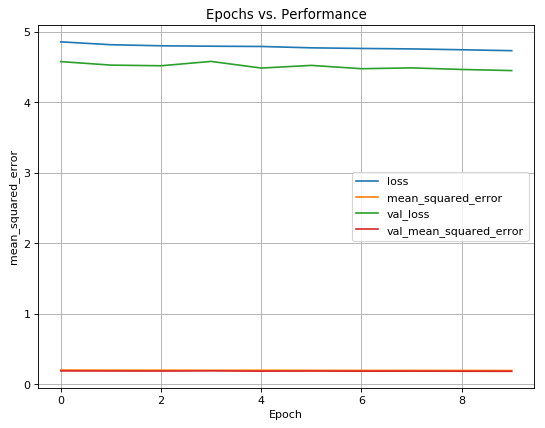

In [91]:
plot_history(history)

In [76]:
num_images = 5
idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
def plot_reconstructionPP(decoded_imgs, data_dir, mode, idxs):
    num_images = len(idxs)
    original_images,_ = next(get_imagesPP(mode, 12))
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(idxs):
        # display original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(bgr2rgb(original_images[i]*255))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        decoded_to_plot = decoded_imgs[idx] * 255
        plt.imshow(bgr2rgb(decoded_to_plot))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
plot_reconstructionPP(decoded_imgs, "../data/segmentation/foregroundBackground/", 'test', idxs)

NameError: name 'get_imagesPP' is not defined

In [92]:
#Decoding images
BATCH_SIZE_TEST = 8
NUM_SAMPLES_TEST =  get_num_images('test','foregroundBackground', '../data/')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

decoded_imgs = segmenter.predict_generator(generate_image_segmentation_labels('test','foregroundBackground' ,BATCH_SIZE_TEST, dataDir='../data/',squashOutput=True),steps=STEPS_TEST)

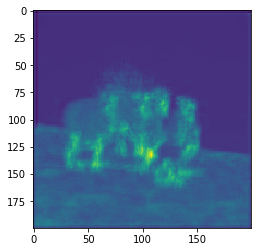

In [105]:
decoded_imgs.shape
plt.imshow(decoded_imgs[105,:,:,0])